# Module 2: Strands SDK

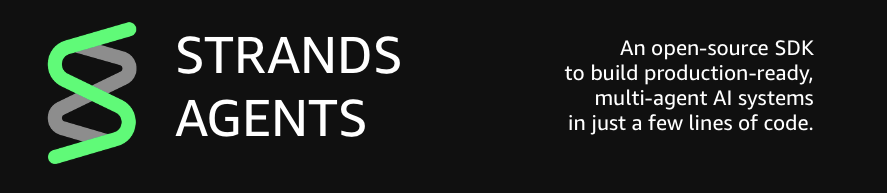

In this module we will build a streamlit application that uses Strands SDK to introduce agentic AI capabilities to your observability application. As we go through this module, you will learn how to use Strands Agents SDK features and tools to easily build production-ready applications at your organization.

**What you'll build:** 

An AWS MSK monitoring application powered by multiple specialized AI agents that work together to analyze clusters, diagnose issues, and execute remediation tasks.

**Core technologies:** 

- Strands Agents SDK (for building AI agents)
- Model Context Protocol or MCP (for connecting to data sources and/or to AWS services)
- Streamlit (for the web interface).

To learn more about Strands Agents open-source SDK, visit this [link](https://strandsagents.com/latest/)

**Pre-requisites:** *sps-module-0-pre-req* must be completed before you can start this module. 

Let's first import all python packages and perform global configuration setup. This includes AWS clients, Streamlit, plotting libraries, the Strands agent framework, and MCP client setup. In Python, import statements load external libraries that provide functionality. Think of them as bringing tools into your workshop. 

The key import is *from strands import Agent, tool* - this gives you the core components to build agents. The Agent class creates AI agents, and the @tool decorator (which we'll use later) turns your Python functions into capabilities that agents can use.

The MCP imports (*ClientSession, StdioServerParameters*) enable your application to communicate with MCP servers, which are specialized programs that expose data and operations (like AWS MSK management) in a standardized way that AI agents can understand.

Go ahead and run the next cell to import all dependencies. You should see *Writing app.py* if everything loads successfully. Using %%writefile magic, we are writing the all code cells into a final streamlit app.py python file. We will run *streamlit run* command at the end. This sets up our streamlit application for web interface.

In [29]:
%%writefile app.py
import streamlit as st
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime, timedelta
import json
import boto3
from strands import Agent, tool
from typing import Dict, List, Any
import signal
import sys
import logging
import threading

# AWS MSK MCP Client Integration
import asyncio
import subprocess
try:
    from mcp import ClientSession, StdioServerParameters
    from mcp.client.stdio import stdio_client
    MCP_AVAILABLE = True
except ImportError:
    MCP_AVAILABLE = False

# Configure logging to handle signal handler errors
logging.basicConfig(level=logging.INFO)

Writing app.py


In the next cell, we are implementing signal handling for graceful shutdown and basic utility functions like getting cluster ARN from cluster name. Go ahead and run this. Additionally, the %%writefile with -a flag appends this section of the code to our existing app.py file.

In [30]:
%%writefile -a app.py

def safe_signal_handler(signum, frame):
    """Handle signals safely without stdout errors"""
    try:
        logging.info('Shutting down MSK monitor...')
    except:
        pass
    finally:
        sys.exit(0)

# Set up signal handlers (only in main thread)
if threading.current_thread() is threading.main_thread():
    signal.signal(signal.SIGINT, safe_signal_handler)
    signal.signal(signal.SIGTERM, safe_signal_handler)

def get_cluster_arn(cluster_name, region):
    """Get cluster ARN from cluster name"""
    try:
        import boto3
        client = boto3.client('kafka', region_name=region)
        response = client.list_clusters()
        
        for cluster in response['ClusterInfoList']:
            if cluster['ClusterName'] == cluster_name:
                return cluster['ClusterArn']
        return None
    except Exception:
        return None

Appending to app.py


### Strands SDK supports MCP Integration.

In the next cell we will define functions for calling **AWS MSK MCP** server tools and formatting responses. This handles the communication with the MCP server and response formatting. This provides you information on how to connect AI agents to external systems using the Model Context Protocol (MCP).

The *run_mcp_tool* function is your bridge to MCP servers. MCP servers are programs that expose specific capabilities (like managing AWS MSK clusters) that AI agents can invoke. The function uses *StdioServerParameters* to configure how to launch the MCP server - in this case, it runs *uvx awslabs.aws-msk-mcp-server@latest --allow-writes*. The *async/await* pattern handles asynchronous operations, and *asyncio.run()* wraps it for synchronous use in Streamlit.

Inside the function, notice the async with *ClientSession(read, write)* as session pattern - this creates a session, initializes it, then calls tools like *session.call_tool(tool_name, arguments)*. The *format_mcp_response* function transforms technical JSON responses into user-friendly natural language. For example, when a storage update succeeds, instead of showing raw JSON, it formats it as "✅ Storage update initiated successfully for cluster 'X'". This separation - MCP handles operations, your code handles presentation - keeps concerns cleanly separated.

Go ahead and run the next cell.

In [31]:
%%writefile -a app.py

def run_mcp_tool(tool_name, arguments=None):
    """Synchronous wrapper for AWS MSK MCP tool calls using configured server"""
    if not MCP_AVAILABLE:
        return "MCP not available - install with: pip install mcp"
    
    async def _call_mcp():
        try:
            import os
            # Create environment that includes current env vars + MCP-specific settings
            mcp_env = os.environ.copy()  # ✅ Inherit all environment variables
            mcp_env.update({
                "FASTMCP_LOG_LEVEL": "ERROR",
                "PYTHONUNBUFFERED": "1"
            })
            
            server_params = StdioServerParameters(
                command="uvx",
                args=["awslabs.aws-msk-mcp-server@latest", "--allow-writes"],
                env=mcp_env  # ✅ Pass complete environment
            )
            
            async with stdio_client(server_params) as (read, write):
                async with ClientSession(read, write) as session:
                    await session.initialize()
                    result = await session.call_tool(tool_name, arguments or {})
                    return result.content[0].text if result.content else ""
        except Exception as e:
            return f"MCP Error: {str(e)}"
    
    try:
        return asyncio.run(_call_mcp())
    except Exception as e:
        logging.error(f"MCP tool call failed: {e}")
        return f"MCP Error: {str(e)}"

def format_mcp_response(raw_response, operation_type, cluster_name):
    """Format MCP response into natural language"""
    try:
        # Try to parse as JSON first
        import json
        if raw_response.startswith('{') or raw_response.startswith('['):
            data = json.loads(raw_response)
            
            if operation_type == "reboot_broker":
                if "success" in str(data).lower():
                    return f"✅ Successfully initiated reboot for the requested brokers in cluster '{cluster_name}'. The brokers will restart shortly and rejoin the cluster automatically."
                else:
                    return f"❌ Failed to reboot brokers in cluster '{cluster_name}'. Error: {data.get('error', 'Unknown error')}"
            
            elif operation_type == "storage_update":
                if "success" in str(data).lower() or "operation" in str(data).lower():
                    return f"✅ Storage update initiated successfully for cluster '{cluster_name}'. The operation is now in progress and will complete automatically."
                else:
                    return f"❌ Failed to update storage for cluster '{cluster_name}'. Error: {data.get('error', 'Unknown error')}"
            
            elif operation_type == "broker_count":
                if "success" in str(data).lower() or "operation" in str(data).lower():
                    return f"✅ Broker count scaling initiated successfully for cluster '{cluster_name}'. New brokers will be added automatically."
                else:
                    return f"❌ Failed to scale broker count for cluster '{cluster_name}'. Error: {data.get('error', 'Unknown error')}"
            
            elif operation_type == "cluster_info":
                # Extract key information from cluster info
                info_summary = f"📊 **Cluster Information for '{cluster_name}':**\n\n"
                if isinstance(data, dict):
                    if 'broker_count' in str(data).lower():
                        info_summary += f"• **Brokers:** {data.get('broker_count', 'N/A')}\n"
                    if 'instance_type' in str(data).lower():
                        info_summary += f"• **Instance Type:** {data.get('instance_type', 'N/A')}\n"
                    if 'storage' in str(data).lower():
                        info_summary += f"• **Storage:** {data.get('storage_info', 'N/A')}\n"
                    if 'kafka_version' in str(data).lower():
                        info_summary += f"• **Kafka Version:** {data.get('kafka_version', 'N/A')}\n"
                return info_summary + f"\n*Full details available in the raw response if needed.*"
            
            elif operation_type == "telemetry":
                return f"📈 **Real-time Metrics for '{cluster_name}':**\n\nTelemetry data has been retrieved successfully. The cluster monitoring data shows current performance metrics and health indicators.\n\n*Detailed metrics are available in the monitoring dashboard.*"
            
            elif operation_type == "best_practices":
                return f"💡 **Best Practices Recommendations for '{cluster_name}':**\n\nI've analyzed your cluster configuration and generated optimization recommendations based on AWS best practices.\n\n*Review the detailed recommendations to improve performance and cost efficiency.*"
            
            elif operation_type == "operation_status":
                status = data.get('state', 'UNKNOWN') if isinstance(data, dict) else 'UNKNOWN'
                return f"🔍 **Operation Status:** {status}\n\nThe cluster operation is currently {status.lower()}. Monitor the progress in the AWS console for detailed updates."
            
            elif operation_type == "global_info":
                cluster_count = len(data) if isinstance(data, list) else data.get('cluster_count', 'N/A')
                return f"🌐 **Global MSK Overview:**\n\nFound {cluster_count} MSK clusters in the region. All cluster information has been retrieved successfully."
        
        # If not JSON or parsing failed, return formatted raw response
        if "error" in raw_response.lower():
            return f"❌ **Error:** {raw_response}"
        elif "success" in raw_response.lower():
            return f"✅ **Success:** Operation completed successfully.\n\n{raw_response}"
        else:
            return f"ℹ️ **Response:** {raw_response}"
            
    except:
        # Fallback to raw response with basic formatting
        if "error" in raw_response.lower():
            return f"❌ **Error:** {raw_response}"
        elif "success" in raw_response.lower():
            return f"✅ **Success:** {raw_response}"
        else:
            return raw_response

Appending to app.py


### Processing MCP

Next, let's define the main function that processes natural language requests and routes them to appropriate MCP tools. 

The *process_mcp_request* function is the intelligent router that interprets what users want and executes it. It uses pattern matching (*if any(word in prompt_lower for word in ['reboot', 'restart'])*) to detect intent from conversational input. When it identifies an intent (like rebooting a broker), it extracts parameters using regular expressions (*broker_ids = re.findall(r'broker\s*(\d+)', prompt_lower)*), calls the appropriate MCP tool, then routes the response through a Strands agent for natural language formatting.

Notice the hybrid approach: **deterministic routing for reliability** (if/elif chains ensure predictable routing) combined with **LLM-based formatting for flexibility** (agents explain results in natural language). The context dictionary passed to agents provides situational awareness - it includes the selected cluster, region, and raw MCP response. This allows agents to provide contextual explanations like "Broker 1 in your production-kafka cluster is being rebooted."

Go ahead and execute the next cell.

In [32]:
%%writefile -a app.py

def process_mcp_request(prompt, cluster_name, region):
    """Process MCP request using AWS MSK MCP server with Bedrock response formatting"""
    prompt_lower = prompt.lower()
    
    # Extract numbers from prompt
    import re
    numbers = re.findall(r'\d+', prompt)
    
    if any(word in prompt_lower for word in ['reboot', 'restart']) and 'broker' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            # Extract broker IDs if specified
            broker_ids = re.findall(r'broker\s*(\d+)', prompt_lower)
            raw_response = run_mcp_tool("reboot_broker", {
                "cluster_arn": cluster_arn,
                "broker_ids": broker_ids if broker_ids else None,
                "region": region
            })
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("troubleshoot", 
                f"Explain broker reboot operation for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['instance', 'broker type', 'update type']) and ('update' in prompt_lower or 'change' in prompt_lower):
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            # Extract instance type if specified
            instance_match = re.search(r'(kafka\.\w+\.\w+)', prompt_lower)
            if instance_match:
                instance_type = instance_match.group(1)
                raw_response = run_mcp_tool("update_broker_type", {
                    "cluster_arn": cluster_arn,
                    "instance_type": instance_type,
                    "region": region
                })
            else:
                raw_response = "Please specify the target instance type (e.g., kafka.m5.large)"
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("troubleshoot", 
                f"Explain broker type update for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['operation', 'status']) and ('arn' in prompt_lower or 'check' in prompt_lower):
        # Extract operation ARN if provided
        arn_match = re.search(r'(arn:aws:kafka:[^:]+:[^:]+:operation/[^\s]+)', prompt)
        if arn_match:
            operation_arn = arn_match.group(1)
            raw_response = run_mcp_tool("describe_cluster_operation", {
                "cluster_operation_arn": operation_arn,
                "region": region
            })
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("troubleshoot", 
                f"Explain operation status for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return "Please provide the operation ARN to check status"
    
    elif any(word in prompt_lower for word in ['health', 'status']) and 'cluster' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_info", {
                "cluster_arn": cluster_arn,
                "region": region
            })
            # Use troubleshoot agent to format response with Bedrock
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("troubleshoot", 
                f"Explain cluster health status for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif any(word in prompt_lower for word in ['storage', 'disk', 'volume']):
        if ('increase' in prompt_lower or 'update' in prompt_lower) and numbers:
            target_gib = int(numbers[0])
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                raw_response = run_mcp_tool("update_broker_storage", {
                    "cluster_name": cluster_name,
                    "cluster_arn": cluster_arn,
                    "volume_size_gb": target_gib,
                    "region": region
                })
                # Use troubleshoot agent to format response with Bedrock
                context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
                return st.session_state.agent_manager.query_agent("troubleshoot", 
                    f"Explain storage update operation for {cluster_name} to {target_gib} GiB. Raw data: {raw_response}", context)
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
        else:
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                raw_response = run_mcp_tool("get_cluster_info", {
                    "cluster_arn": cluster_arn,
                    "region": region
                })
                # Use troubleshoot agent to format response with Bedrock
                context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
                return st.session_state.agent_manager.query_agent("troubleshoot", 
                    f"Explain storage information for {cluster_name}. Raw data: {raw_response}", context)
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif 'broker count' in prompt_lower or 'scale' in prompt_lower:
        if ('increase' in prompt_lower or 'update' in prompt_lower) and numbers:
            new_count = int(numbers[0])
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                raw_response = run_mcp_tool("update_broker_count", {
                    "cluster_name": cluster_name,
                    "cluster_arn": cluster_arn,
                    "target_number_of_broker_nodes": new_count,
                    "region": region
                })
                # Use troubleshoot agent to format response with Bedrock
                context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
                return st.session_state.agent_manager.query_agent("troubleshoot", 
                    f"Explain broker scaling operation for {cluster_name} to {new_count} brokers. Raw data: {raw_response}", context)
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
        else:
            cluster_arn = get_cluster_arn(cluster_name, region)
            if cluster_arn:
                raw_response = run_mcp_tool("get_cluster_info", {
                    "cluster_arn": cluster_arn,
                    "region": region
                })
                # Use troubleshoot agent to format response with Bedrock
                context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
                return st.session_state.agent_manager.query_agent("troubleshoot", 
                    f"Explain broker configuration for {cluster_name}. Raw data: {raw_response}", context)
            else:
                return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif 'telemetry' in prompt_lower or 'metrics' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            from datetime import datetime, timedelta
            end_time = datetime.utcnow()
            start_time = end_time - timedelta(hours=1)
            
            raw_response = run_mcp_tool("get_cluster_telemetry", {
                "action": "metrics",
                "cluster_arn": cluster_arn,
                "region": region,
                "kwargs": {
                    "start_time": start_time.isoformat(),
                    "end_time": end_time.isoformat(),
                    "period": 300,
                    "metrics": ["GlobalTopicCount", "GlobalPartitionCount", "OfflinePartitionsCount", "UnderReplicatedPartitions"]
                }
            })
            # Use health agent to format response with Bedrock
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("health", 
                f"Explain telemetry metrics for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    elif 'best practices' in prompt_lower or 'recommendations' in prompt_lower:
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_best_practices", {
                "cluster_name": cluster_name,
                "cluster_arn": cluster_arn,
                "region": region
            })
            # Use troubleshoot agent to format response with Bedrock
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("troubleshoot", 
                f"Explain best practices recommendations for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"
    
    else:
        # Default to cluster info
        cluster_arn = get_cluster_arn(cluster_name, region)
        if cluster_arn:
            raw_response = run_mcp_tool("get_cluster_info", {
                "cluster_arn": cluster_arn,
                "region": region
            })
            # Use cluster agent to format response with Bedrock
            context = {'selected_cluster': cluster_name, 'region': region, 'raw_mcp_response': raw_response}
            return st.session_state.agent_manager.query_agent("cluster", 
                f"Explain cluster information for {cluster_name}. Raw data: {raw_response}", context)
        else:
            return f"❌ Cluster '{cluster_name}' not found in region {region}"

Appending to app.py


### AWS Helper Functions

Next, let's add some helper functions for interacting with AWS services - getting MSK clusters, CloudWatch metrics, broker nodes, and both historical and instant metrics. Note that we are using boto3 client to interact with AWS services.

In [33]:
%%writefile -a app.py

# AWS Helper Functions
def get_msk_clusters(region='us-west-2'):
    """Get all MSK clusters in the specified AWS region."""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_clusters()
        clusters = response.get('ClusterInfoList', [])
        return [{
            'name': c['ClusterName'],
            'arn': c['ClusterArn'],
            'state': c['State'],
            'kafka_version': c['CurrentBrokerSoftwareInfo']['KafkaVersion']
        } for c in clusters]
    except Exception as e:
        return []

def get_cloudwatch_metrics(cluster_name, metric_name, hours=24, region='us-west-2'):
    """Get CloudWatch metrics for MSK cluster."""
    try:
        cloudwatch = boto3.client('cloudwatch', region_name=region)
        end_time = datetime.now()
        start_time = end_time - timedelta(hours=hours)
        
        # Use 1-minute period for instant current metrics
        period = 60
        
        response = cloudwatch.get_metric_statistics(
            Namespace='AWS/Kafka',
            MetricName=metric_name,
            Dimensions=[{'Name': 'Cluster Name', 'Value': cluster_name}],
            StartTime=start_time,
            EndTime=end_time,
            Period=period,
            Statistics=['Average', 'Maximum']
        )
        
        return response['Datapoints']
    except Exception:
        return []

def get_broker_nodes(cluster_arn, region='us-west-2'):
    """Get broker node IDs for MSK cluster."""
    try:
        kafka_client = boto3.client('kafka', region_name=region)
        response = kafka_client.list_nodes(ClusterArn=cluster_arn)
        
        return [str(int(node['BrokerNodeInfo']['BrokerId'])) 
                for node in response.get('NodeInfoList', [])
                if node['NodeType'] == 'BROKER']
    except Exception:
        return []

def get_broker_metrics(cluster_name, broker_id, metric_name, hours=24, region='us-west-2'):
    """Get CloudWatch metrics for specific broker."""
    try:
        cloudwatch = boto3.client('cloudwatch', region_name=region)
        end_time = datetime.now()
        start_time = end_time - timedelta(hours=hours)
        
        # Use 1-minute period for instant current metrics
        period = 60
        
        response = cloudwatch.get_metric_statistics(
            Namespace='AWS/Kafka',
            MetricName=metric_name,
            Dimensions=[
                {'Name': 'Cluster Name', 'Value': cluster_name},
                {'Name': 'Broker ID', 'Value': str(broker_id)}
            ],
            StartTime=start_time,
            EndTime=end_time,
            Period=period,
            Statistics=['Average', 'Maximum']
        )
        
        return response['Datapoints']
    except Exception:
        return []

def get_instant_broker_metrics(cluster_name, broker_id, metric_name, region='us-west-2'):
    """Get instant current metrics for specific broker (last 5 minutes)."""
    try:
        cloudwatch = boto3.client('cloudwatch', region_name=region)
        end_time = datetime.now()
        start_time = end_time - timedelta(minutes=5)  # Last 5 minutes only
        
        response = cloudwatch.get_metric_statistics(
            Namespace='AWS/Kafka',
            MetricName=metric_name,
            Dimensions=[
                {'Name': 'Cluster Name', 'Value': cluster_name},
                {'Name': 'Broker ID', 'Value': str(broker_id)}
            ],
            StartTime=start_time,
            EndTime=end_time,
            Period=60,  # 1-minute granularity
            Statistics=['Average', 'Maximum']
        )
        
        return response['Datapoints']
    except Exception:
        return []

Appending to app.py


### Strands SDK Agent Tool Definition

In the next section, we will learn how to give AI agents capabilities using the @tool decorator - this is fundamental to Strands SDK. In the next few lines of code, the Strands Agent tool decorators define the capabilities of each specialized agent - cluster discovery, health analysis, disk monitoring, diagnostics, storage management, configuration retrieval, and broker reboot. 

This is where Strands SDK's power becomes clear. The @tool decorator transforms regular Python functions into capabilities that AI agents can discover and invoke. When you write:
```
@tool
def monitor_disk_usage(cluster_name: str, region: str = 'us-west-2') -> str:
    """Monitor disk usage across all brokers in the cluster."""
```
Strands automatically: 
- Reads the function signature to understand parameters
- Uses the docstring to explain to the LLM what the tool does
- Converts the function into a format agents can invoke, and
- Handles parameter passing and result formatting.

The docstring is crucial - it's what the LLM reads to decide when to use this tool.

Each tool should return JSON strings (notice *return json.dumps(...)*) because this provides structured data that both LLMs and your application can parse. 
- The *discover_clusters* tool finds all clusters
- *analyze_cluster_health* checks controller status
- *monitor_disk_usage* aggregates disk metrics
- *manage_storage_update* tool demonstrates state management with three actions: 'recommend' (advisory), 'update' (operational), and 'status' (tracking).

Additionally, notice how tools can call other tools - *manage_storage_update* internally calls *monitor_disk_usage* when making recommendations.

Let's go ahead and execute the next cell. 

In [34]:
%%writefile -a app.py

# Agent Tools
@tool
def discover_clusters(region: str = 'us-west-2') -> str:
    """Discover and validate MSK clusters in the specified region."""
    clusters = get_msk_clusters(region)
    
    result = {
        'total_clusters': len(clusters),
        'clusters': clusters,
        'healthy_clusters': [c for c in clusters if c['state'] == 'ACTIVE'],
        'unhealthy_clusters': [c for c in clusters if c['state'] != 'ACTIVE']
    }
    
    return json.dumps(result, indent=2)

@tool
def analyze_cluster_health(cluster_name: str, region: str = 'us-west-2') -> str:
    """Analyze overall cluster health including controller status."""
    controller_data = get_cloudwatch_metrics(cluster_name, 'ActiveControllerCount', 1, region)
    
    health_status = {
        'cluster_name': cluster_name,
        'controller_status': 'unknown',
        'controller_count': 0,
        'health_score': 0,
        'issues': []
    }
    
    if controller_data:
        latest_controller = controller_data[-1].get('Average', 0)
        health_status['controller_count'] = latest_controller
        
        if 0.2 <= latest_controller <= 0.5:
            health_status['controller_status'] = 'healthy'
            health_status['health_score'] = 100
        else:
            health_status['controller_status'] = 'critical'
            health_status['health_score'] = 0
            health_status['issues'].append(f"Controller anomaly: {latest_controller} active controllers")
    
    return json.dumps(health_status, indent=2)

@tool
def monitor_disk_usage(cluster_name: str, region: str = 'us-west-2') -> str:
    """Monitor disk usage across all brokers in the cluster."""
    clusters = get_msk_clusters(region)
    cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
    
    if not cluster_info:
        return json.dumps({'error': f'Cluster {cluster_name} not found'})
    
    broker_ids = get_broker_nodes(cluster_info['arn'], region)
    disk_status = {
        'cluster_name': cluster_name,
        'total_brokers': len(broker_ids),
        'broker_status': {},
        'critical_brokers': [],
        'warning_brokers': [],
        'overall_disk_health': 'healthy',
        'timestamp': datetime.now().isoformat(),
        'data_freshness': 'instant (1-minute)'
    }
    
    for broker_id in broker_ids:
        # Get instant metrics (last 5 minutes)
        broker_data = get_instant_broker_metrics(cluster_name, broker_id, 'KafkaDataLogsDiskUsed', region)
        if broker_data:
            # Get the most recent data point
            latest_data = max(broker_data, key=lambda x: x['Timestamp'])
            usage = latest_data.get('Maximum', 0)
            disk_status['broker_status'][broker_id] = {
                'usage_percent': usage,
                'timestamp': latest_data['Timestamp'].isoformat()
            }
            
            if usage > 90:
                disk_status['critical_brokers'].append(f"Broker {broker_id}: {usage:.1f}%")
                disk_status['overall_disk_health'] = 'critical'
            elif usage > 60:
                disk_status['warning_brokers'].append(f"Broker {broker_id}: {usage:.1f}%")
                if disk_status['overall_disk_health'] == 'healthy':
                    disk_status['overall_disk_health'] = 'warning'
    
    return json.dumps(disk_status, indent=2)

@tool
def diagnose_issues(cluster_name: str, region: str = 'us-west-2') -> str:
    """Diagnose issues and provide recommendations."""
    # Get health data
    controller_data = get_cloudwatch_metrics(cluster_name, 'ActiveControllerCount', 1, region)
    disk_data = get_cloudwatch_metrics(cluster_name, 'KafkaDataLogsDiskUsed', 1, region)
    
    diagnosis = {
        'cluster_name': cluster_name,
        'issues_found': [],
        'recommendations': [],
        'severity': 'low'
    }
    
    # Controller issues
    if controller_data:
        controller_count = controller_data[-1].get('Average', 0)
        if controller_count == 0:
            diagnosis['issues_found'].append("No active controller - cluster leadership failure")
            diagnosis['recommendations'].append("Check broker connectivity and restart brokers if needed")
            diagnosis['severity'] = 'critical'
        elif controller_count > 1:
            diagnosis['issues_found'].append("Multiple active controllers - split brain scenario")
            diagnosis['recommendations'].append("Investigate network partitions and broker logs")
            diagnosis['severity'] = 'critical'
    
    # Disk issues
    if disk_data:
        disk_usage = disk_data[-1].get('Maximum', 0)
        if disk_usage > 90:
            diagnosis['issues_found'].append(f"Critical disk usage: {disk_usage:.1f}%")
            diagnosis['recommendations'].append("Immediate action: Clean up old logs or add storage")
            diagnosis['severity'] = 'critical'
        elif disk_usage > 65:
            diagnosis['issues_found'].append(f"High disk usage: {disk_usage:.1f}%")
            diagnosis['recommendations'].append("Monitor closely and plan storage expansion")
            if diagnosis['severity'] != 'critical':
                diagnosis['severity'] = 'medium'
    
    if not diagnosis['issues_found']:
        diagnosis['recommendations'].append("Cluster appears healthy - continue regular monitoring")
    
    return json.dumps(diagnosis, indent=2)

def create_health_metrics_graph(cluster_name, region='us-west-2', hours=24):
    """Create CloudWatch metrics graph for cluster health."""
    controller_data = get_cloudwatch_metrics(cluster_name, 'ActiveControllerCount', hours, region)
    
    if not controller_data:
        return None
    
    df = pd.DataFrame(controller_data)
    df['Timestamp'] = pd.to_datetime(df['Timestamp'])
    df = df.sort_values('Timestamp')
    
    fig = go.Figure()
    fig.add_trace(go.Scatter(
        x=df['Timestamp'], 
        y=df['Average'],
        mode='lines+markers',
        name='Active Controller Count',
        line=dict(color='blue', width=2)
    ))
    
    fig.update_layout(
        title=f'MSK Cluster Health - {cluster_name}',
        xaxis_title='Time',
        yaxis_title='Active Controller Count',
        height=400
    )
    
    return fig

def create_disk_metrics_graph(cluster_name, region='us-west-2', hours=24):
    """Create CloudWatch metrics graph for broker disk usage."""
    clusters = get_msk_clusters(region)
    cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
    
    if not cluster_info:
        return None
    
    broker_ids = get_broker_nodes(cluster_info['arn'], region)
    
    if not broker_ids:
        return None
    
    fig = go.Figure()
    
    for broker_id in broker_ids:
        broker_data = get_broker_metrics(cluster_name, broker_id, 'KafkaDataLogsDiskUsed', hours, region)
        
        if broker_data:
            df = pd.DataFrame(broker_data)
            df['Timestamp'] = pd.to_datetime(df['Timestamp'])
            df = df.sort_values('Timestamp')
            
            fig.add_trace(go.Scatter(
                x=df['Timestamp'],
                y=df['Maximum'],
                mode='lines+markers',
                name=f'Broker {broker_id}',
                line=dict(width=2)
            ))
    
    fig.add_hline(y=80, line_dash="dash", line_color="orange", annotation_text="Warning (65%)")
    fig.add_hline(y=90, line_dash="dash", line_color="red", annotation_text="Critical (80%)")
    
    fig.update_layout(
        title=f'MSK Broker Disk Usage - {cluster_name}',
        xaxis_title='Time',
        yaxis_title='Disk Usage (%)',
        height=400
    )
    
    return fig

# Storage Update Functions
def get_cluster_version(cluster_arn, region='us-west-2'):
    """Get current cluster version"""
    client = boto3.client('kafka', region_name=region)
    response = client.describe_cluster(ClusterArn=cluster_arn)
    return response['ClusterInfo']['CurrentVersion']

def update_msk_storage(cluster_arn, target_gib, region='us-west-2'):
    """Update MSK cluster storage"""
    try:
        client = boto3.client('kafka', region_name=region)
        response = client.update_storage(
            ClusterArn=cluster_arn,
            CurrentVersion=get_cluster_version(cluster_arn, region),
            VolumeSizeGB=target_gib
        )
        return True, response['ClusterOperationArn']
    except Exception as e:
        return False, str(e)

def update_mcp_broker_count(cluster_name, new_count, region='us-west-2'):
    """Update MSK cluster broker count"""
    try:
        clusters = get_msk_clusters(region)
        cluster_arn = None
        for cluster in clusters:
            if cluster['ClusterName'] == cluster_name:
                cluster_arn = cluster['ClusterArn']
                break
        
        if not cluster_arn:
            return {"error": f"Cluster {cluster_name} not found"}
        
        client = boto3.client('kafka', region_name=region)
        current_version = get_cluster_version(cluster_arn, region)
        
        response = client.update_broker_count(
            ClusterArn=cluster_arn,
            CurrentVersion=current_version,
            TargetNumberOfBrokerNodes=new_count
        )
        return {"success": True, "operation_arn": response['ClusterOperationArn']}
    except Exception as e:
        return {"error": str(e)}

def check_operation_status(operation_arn, region='us-west-2'):
    """Check MSK operation status with detailed information"""
    try:
        client = boto3.client('kafka', region_name=region)
        response = client.describe_cluster_operation(ClusterOperationArn=operation_arn)
        operation_info = response['ClusterOperationInfo']
        
        return {
            'state': operation_info['State'],
            'operation_type': operation_info['OperationType'],
            'creation_time': operation_info['CreationTime'],
            'end_time': operation_info.get('EndTime'),
            'error_info': operation_info.get('ErrorInfo', {}),
            'target_config': operation_info.get('TargetClusterInfo', {}),
            'source_config': operation_info.get('SourceClusterInfo', {})
        }
    except Exception as e:
        return {'state': 'UNKNOWN', 'error': str(e)}

@tool
def manage_storage_update(cluster_name: str, action: str, target_gib: int = None, operation_arn: str = None, region: str = 'us-west-2') -> str:
    """Manage MSK cluster storage updates - initiate, check status, or get recommendations."""
    clusters = get_msk_clusters(region)
    cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
    
    if not cluster_info:
        return json.dumps({'error': f'Cluster {cluster_name} not found'})
    
    if action == 'recommend':
        # Get current disk usage and recommend storage size
        disk_data = json.loads(monitor_disk_usage(cluster_name, region))
        recommendations = {
            'cluster_name': cluster_name,
            'current_disk_health': disk_data.get('overall_disk_health', 'unknown'),
            'critical_brokers': disk_data.get('critical_brokers', []),
            'warning_brokers': disk_data.get('warning_brokers', []),
            'recommendations': []
        }
        
        if disk_data.get('overall_disk_health') == 'critical':
            recommendations['recommendations'].append("Immediate storage increase recommended (50-100% increase)")
            recommendations['suggested_increase'] = "100-200 GiB"
        elif disk_data.get('overall_disk_health') == 'warning':
            recommendations['recommendations'].append("Proactive storage increase recommended (25-50% increase)")
            recommendations['suggested_increase'] = "50-100 GiB"
        else:
            recommendations['recommendations'].append("Storage levels are healthy, no immediate action needed")
        
        return json.dumps(recommendations, indent=2)
    
    elif action == 'update' and target_gib:
        # Initiate storage update
        success, result = update_msk_storage(cluster_info['arn'], target_gib, region)
        
        response = {
            'cluster_name': cluster_name,
            'action': 'storage_update',
            'success': success,
            'target_gib': target_gib
        }
        
        if success:
            response['operation_arn'] = result
            response['message'] = f"Storage update initiated successfully. Target size: {target_gib} GiB"
        else:
            response['error'] = result
            response['message'] = f"Storage update failed: {result}"
        
        return json.dumps(response, indent=2)
    
    elif action == 'status' and operation_arn:
        # Check operation status
        status_info = check_operation_status(operation_arn, region)
        
        response = {
            'cluster_name': cluster_name,
            'action': 'status_check',
            'operation_arn': operation_arn,
            'status': status_info
        }
        
        return json.dumps(response, indent=2)
    
    else:
        return json.dumps({'error': 'Invalid action or missing parameters'})

@tool
def get_cluster_configuration(cluster_name: str, region: str = 'us-west-2') -> str:
    """Get detailed cluster configuration including auth mechanism, storage, and basic info."""
    try:
        clusters = get_msk_clusters(region)
        cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
        
        if not cluster_info:
            return json.dumps({'error': f'Cluster {cluster_name} not found'})
        
        client = boto3.client('kafka', region_name=region)
        response = client.describe_cluster(ClusterArn=cluster_info['arn'])
        cluster_details = response['ClusterInfo']
        
        config = {
            'cluster_name': cluster_name,
            'cluster_arn': cluster_info['arn'],
            'state': cluster_details['State'],
            'kafka_version': cluster_details['CurrentBrokerSoftwareInfo']['KafkaVersion'],
            'number_of_broker_nodes': cluster_details['NumberOfBrokerNodes'],
            'instance_type': cluster_details['BrokerNodeGroupInfo']['InstanceType'],
            'storage_info': {
                'volume_size': cluster_details['BrokerNodeGroupInfo']['StorageInfo']['EBSStorageInfo']['VolumeSize'],
                'volume_type': cluster_details['BrokerNodeGroupInfo']['StorageInfo']['EBSStorageInfo'].get('ProvisionedThroughput', {}).get('VolumeType', 'gp2')
            },
            'client_authentication': {
                'sasl': cluster_details.get('ClientAuthentication', {}).get('Sasl', {}),
                'tls': cluster_details.get('ClientAuthentication', {}).get('Tls', {}),
                'unauthenticated': cluster_details.get('ClientAuthentication', {}).get('Unauthenticated', {})
            },
            'encryption_info': {
                'encryption_at_rest': cluster_details.get('EncryptionInfo', {}).get('EncryptionAtRest', {}),
                'encryption_in_transit': cluster_details.get('EncryptionInfo', {}).get('EncryptionInTransit', {})
            },
            'enhanced_monitoring': cluster_details.get('EnhancedMonitoring', 'DEFAULT'),
            'open_monitoring': cluster_details.get('OpenMonitoring', {}),
            'creation_time': cluster_details['CreationTime'].isoformat() if cluster_details.get('CreationTime') else None
        }
        
        return json.dumps(config, indent=2, default=str)
        
    except Exception as e:
        return json.dumps({'error': f'Failed to get cluster configuration: {str(e)}'})

@tool
def reboot_broker_nodes(cluster_name: str, broker_ids: List[str] = None, region: str = 'us-west-2') -> str:
    """Reboot MSK broker nodes using direct AWS API calls."""
    try:
        clusters = get_msk_clusters(region)
        cluster_info = next((c for c in clusters if c['name'] == cluster_name), None)
        
        if not cluster_info:
            return json.dumps({'error': f'Cluster {cluster_name} not found'})
        
        cluster_arn = cluster_info['arn']
        
        # Get all broker nodes if none specified
        if not broker_ids:
            broker_ids = get_broker_nodes(cluster_arn, region)
        
        if not broker_ids:
            return json.dumps({'error': 'No broker nodes found'})
        
        client = boto3.client('kafka', region_name=region)
        
        # Reboot broker nodes
        response = client.reboot_broker(
            ClusterArn=cluster_arn,
            BrokerIds=broker_ids
        )
        
        result = {
            'cluster_name': cluster_name,
            'action': 'reboot_brokers',
            'success': True,
            'broker_ids': broker_ids,
            'operation_arn': response.get('ClusterOperationArn'),
            'message': f"Successfully initiated reboot for brokers {', '.join(broker_ids)} in cluster {cluster_name}"
        }
        
        return json.dumps(result, indent=2)
        
    except Exception as e:
        error_result = {
            'cluster_name': cluster_name,
            'action': 'reboot_brokers',
            'success': False,
            'error': str(e),
            'message': f"Failed to reboot brokers in cluster {cluster_name}: {str(e)}"
        }
        return json.dumps(error_result, indent=2)

@tool
def coordinate_analysis(cluster_name: str, region: str = 'us-west-2') -> str:
    """Coordinate analysis across all monitoring agents."""
    # Gather data from all agents
    cluster_discovery = json.loads(discover_clusters(region))
    health_analysis = json.loads(analyze_cluster_health(cluster_name, region))
    disk_monitoring = json.loads(monitor_disk_usage(cluster_name, region))
    issue_diagnosis = json.loads(diagnose_issues(cluster_name, region))
    
    # Compile comprehensive report
    comprehensive_report = {
        'timestamp': datetime.now().isoformat(),
        'cluster_name': cluster_name,
        'region': region,
        'discovery': cluster_discovery,
        'health': health_analysis,
        'disk': disk_monitoring,
        'diagnosis': issue_diagnosis,
        'overall_status': 'healthy'
    }
    
    # Determine overall status
    if (health_analysis.get('controller_status') == 'critical' or 
        disk_monitoring.get('overall_disk_health') == 'critical' or
        issue_diagnosis.get('severity') == 'critical'):
        comprehensive_report['overall_status'] = 'critical'
    elif (disk_monitoring.get('overall_disk_health') == 'warning' or
          issue_diagnosis.get('severity') == 'medium'):
        comprehensive_report['overall_status'] = 'warning'
    
    return json.dumps(comprehensive_report, indent=2)

Appending to app.py


### Strands SDK Agent Manager - Orchestrating Multiple Specialized Agents

The MSKAgentManager class that orchestrates all specialized agents using the Strands framework. Each agent is configured with specific tools and uses Claude Sonnet for intelligent responses.

Each *Agent()* instantiation creates an independent AI agent powered by Claude 3.5 Sonnet (via Amazon Bedrock). The *tools* parameter determines what that agent can do - *cluster_agent* can only discover clusters, while *troubleshoot_agent* has access to diagnostic, storage management, reboot, and configuration tools. This specialization creates focused agents that excel at specific domains.

The *query_agent* method routes requests to the appropriate agent. Notice how it prepends context to queries: *context_str = f"Context: {json.dumps(context)}\n\nQuery: {query}"*. This gives agents situational awareness about selected clusters, regions, and ongoing operations. The try-except wrapper ensures agent errors are caught and returned as readable messages rather than crashing the application. This pattern - creating specialized agents and routing intelligently - is how you build scalable multi-agent systems with Strands SDK.

Let's run the next cell!

In [35]:
%%writefile -a app.py

# Agent Classes
class MSKAgentManager:
    def __init__(self):
        self.cluster_agent = Agent(
            tools=[discover_clusters],
            model="anthropic.claude-3-5-sonnet-20241022-v2:0"
        )
        
        self.health_agent = Agent(
            tools=[analyze_cluster_health],
            model="anthropic.claude-3-5-sonnet-20241022-v2:0"
        )
        
        self.disk_agent = Agent(
            tools=[monitor_disk_usage],
            model="anthropic.claude-3-5-sonnet-20241022-v2:0"
        )
        
        self.troubleshoot_agent = Agent(
            tools=[diagnose_issues, manage_storage_update, reboot_broker_nodes, get_cluster_configuration],
            model="anthropic.claude-3-5-sonnet-20241022-v2:0"
        )
        
        self.coordinator_agent = Agent(
            tools=[coordinate_analysis, discover_clusters, analyze_cluster_health, 
                   monitor_disk_usage, diagnose_issues, manage_storage_update, reboot_broker_nodes, get_cluster_configuration],
            model="anthropic.claude-3-5-sonnet-20241022-v2:0"
        )
    
    def query_agent(self, agent_type: str, query: str, context: Dict[str, Any] = None):
        """Query specific agent with context."""
        try:
            context_str = f"Context: {json.dumps(context, indent=2)}\n\nQuery: {query}" if context else query
            
            if agent_type == "cluster":
                return str(self.cluster_agent(context_str))
            elif agent_type == "health":
                return str(self.health_agent(context_str))
            elif agent_type == "disk":
                return str(self.disk_agent(context_str))
            elif agent_type == "troubleshoot":
                return str(self.troubleshoot_agent(context_str))
            elif agent_type == "coordinator":
                return str(self.coordinator_agent(context_str))
            else:
                return "Unknown agent type"
        except Exception as e:
            return f"Error querying {agent_type} agent: {str(e)}"

Appending to app.py


### Session Management

The next code block initializes Streamlit session state for agents and chat history and then creates the main application header and sidebar configuration.

In [36]:
%%writefile -a app.py

# Initialize session state
if 'agent_manager' not in st.session_state:
    st.session_state.agent_manager = MSKAgentManager()
if 'chat_history' not in st.session_state:
    st.session_state.chat_history = []
if 'troubleshoot_chat' not in st.session_state:
    st.session_state.troubleshoot_chat = []
if 'storage_operation' not in st.session_state:
    st.session_state.storage_operation = None

# Main application
st.title("🤖 Amazon MSK Multi-Agent Monitor")
st.markdown("*Specialized AI Agents orchestrating real-time cluster monitoring and insights*")

# Sidebar configuration
st.sidebar.header("Configuration")
region = st.sidebar.selectbox("AWS Region", ["us-west-2", "us-east-1", "eu-west-1"], index=0)
time_range = st.sidebar.slider("Time Range (hours)", 1, 168, 24)

# Agent Status Panel
st.sidebar.header("🤖 Agent Status")
agent_status = {
    "Cluster Details Discovery": "🟢 Active",
    "Broker Health Analysis": "🟢 Active", 
    "Disk Monitoring": "🟢 Active",
    "Troubleshooting": "🟢 Active",
    "Coordinator": "🟢 Active"
}

for agent, status in agent_status.items():
    st.sidebar.text(f"{agent}: {status}")

# Fetch clusters
clusters = get_msk_clusters(region)

if not clusters:
    st.warning("No MSK clusters found in the selected region.")
    st.stop()

# Agent Tabs
tab1, tab2, tab3, tab4, tab5, tab6 = st.tabs([
    "📊 Overview", "🔍 Cluster Details Discovery", "❤️ Broker Health Analysis", 
    "💾 Disk Monitoring", "🔧 Troubleshooting", "🤖 AWS MSK MCP Assistant"
])

selected_cluster = st.selectbox("Select Cluster", [c['name'] for c in clusters])

Appending to app.py


### Logic for Cluster Discovery and Overview - Tab 1 and Tab 2

In the next few blocks of code, we will be building our Streamlit application. The *Overview* tab shows cluster metrics and quick health summary and the *Cluster Discovery* tab lets users discover and analyze all MSK clusters.

In [37]:
%%writefile -a app.py

with tab1:
    st.header("Amazon MSK Cluster Details")
    
    if selected_cluster:
        col1, col2, col3 = st.columns(3)
        
        with col1:
            st.metric("Total Clusters", len(clusters))
        
        with col2:
            active_clusters = len([c for c in clusters if c['state'] == 'ACTIVE'])
            st.metric("Active Clusters", active_clusters)
        
        with col3:
            st.metric("Selected Cluster", selected_cluster)
        
        # Quick health check
        st.subheader("Quick Health Summary of Selected Cluster")
        try:
            health_data = json.loads(analyze_cluster_health(selected_cluster, region))
            disk_data = json.loads(monitor_disk_usage(selected_cluster, region))
            
            col1, col2 = st.columns(2)
            with col1:
                controller_status = health_data.get('controller_status', 'unknown')
                if controller_status == 'healthy':
                    st.success("✅ Controller: Healthy")
                else:
                    st.error("❌ Controller: Issues Detected")
            
            with col2:
                disk_health = disk_data.get('overall_disk_health', 'unknown')
                if disk_health == 'healthy':
                    st.success("✅ Disk Usage: Normal")
                elif disk_health == 'warning':
                    st.warning("⚠️ Disk Usage: Warning")
                else:
                    st.error("❌ Disk Usage: Critical")
        except:
            st.info("Loading health data...")

with tab2:
    st.header("🔍 Cluster Details Discovery Agent")
    
    if st.button("Discover Cluster Details"):
        with st.spinner("Cluster Details Discovery Agent analyzing..."):
            result = st.session_state.agent_manager.query_agent(
                "cluster", 
                f"Discover and analyze all MSK clusters in {region}"
            )
            st.text_area("Discovery Results", result, height=300)

Appending to app.py


### Health and Disk Monitoring - Tab 3 and Tab 4

Next, we will create tabs for MSK cluster health monitoring and Disk utilization monitoring. *Health Analysis* tab shows controller metrics and agent analysis. *Disk Monitoring* tab displays real-time disk usage with auto-refresh capability and historical graphs.

In [38]:
%%writefile -a app.py

with tab3:
    st.header("❤️ Broker Health Analysis Agent")
    
    if selected_cluster:
        # CloudWatch metrics graph
        health_fig = create_health_metrics_graph(selected_cluster, region, time_range)
        if health_fig:
            st.plotly_chart(health_fig, use_container_width=True)
        else:
            st.info("No health metrics data available")
        
        if st.button("Analyze Broker Health"):
            with st.spinner("Broker Health Analysis Agent working..."):
                result = st.session_state.agent_manager.query_agent(
                    "health",
                    f"Analyze the broker health of cluster {selected_cluster} in {region}"
                )
                st.text_area("Broker Health Analysis", result, height=300)

with tab4:
    st.header("💾 Disk Usage Monitoring Agent")
    
    if selected_cluster:
        # Real-time current disk usage
        st.subheader("🔴 Live Disk Usage of brokers in selected cluster (1-minute data)")
        
        col1, col2 = st.columns([3, 1])
        with col2:
            auto_refresh = st.checkbox("Auto-refresh (30s)")
            if st.button("🔄 Refresh Now") or auto_refresh:
                st.rerun()
        
        # Get instant disk metrics
        clusters_info = get_msk_clusters(region)
        cluster_info = next((c for c in clusters_info if c['name'] == selected_cluster), None)
        
        if cluster_info:
            broker_ids = get_broker_nodes(cluster_info['arn'], region)
            
            if broker_ids:
                current_usage = {}
                for broker_id in broker_ids:
                    broker_data = get_instant_broker_metrics(selected_cluster, broker_id, 'KafkaDataLogsDiskUsed', region)
                    if broker_data:
                        latest_data = max(broker_data, key=lambda x: x['Timestamp'])
                        current_usage[broker_id] = {
                            'usage': latest_data.get('Maximum', 0),
                            'timestamp': latest_data['Timestamp']
                        }
                
                # Display current usage
                if current_usage:
                    cols = st.columns(len(broker_ids))
                    for i, (broker_id, data) in enumerate(current_usage.items()):
                        with cols[i]:
                            usage = data['usage']
                            if usage > 90:
                                st.error(f"🔴 Broker {broker_id}\n{usage:.1f}% CRITICAL")
                            elif usage > 80:
                                st.warning(f"🟡 Broker {broker_id}\n{usage:.1f}% WARNING")
                            else:
                                st.success(f"🟢 Broker {broker_id}\n{usage:.1f}% NORMAL")
                            
                            st.caption(f"Updated: {data['timestamp'].strftime('%H:%M:%S')}")
                else:
                    st.info("No current disk usage data available")
        
        # CloudWatch metrics graph
        st.subheader("CloudWatch Disk Usage Metrics")
        disk_fig = create_disk_metrics_graph(selected_cluster, region, time_range)
        if disk_fig:
            st.plotly_chart(disk_fig, use_container_width=True)
        else:
            st.info("No disk metrics data available")
        
        if st.button("Monitor Disk Usage"):
            with st.spinner("Disk Monitoring Agent scanning..."):
                result = st.session_state.agent_manager.query_agent(
                    "disk",
                    f"Monitor disk usage for cluster {selected_cluster} in {region}"
                )
                st.text_area("Disk Monitoring Results", result, height=300)
        
        # Auto-refresh logic
        if auto_refresh:
            import time
            time.sleep(30)
            st.rerun()

Appending to app.py


### Building Troubleshooting Agent

The Troubleshooting tab with AI chat interface is for diagnosing issues, managing storage, and interacting with multiple agent modes. 

The prompt processing logic provides **intelligent query augmentation**. When a user asks about "authentication", the code detects this intent and augments the prompt: *"Get cluster configuration details for {cluster} including authentication mechanisms. Use get_cluster_configuration tool."* This guidance helps the LLM invoke the correct tools. The context dictionary passed to agents includes *selected_cluster*, *region*, and *current_storage_operation*, giving agents full situational awareness. Notice how storage operations are tracked in session state - when users initiate a storage update, the operation ARN is stored, allowing later queries like "what's the status?" to automatically reference the right operation.

In [39]:
%%writefile -a app.py

with tab5:
    st.header("🔧 Troubleshooting Agent")
    
    if selected_cluster:
        col1, col2 = st.columns([2, 1])
        
        with col1:
            st.subheader("💬 Amazon MSK AI Assistant Chat")
            st.caption("Ask about issues, storage updates, cluster details, recommendations, or MSK AWS guide documentation")
            
            # Agent selector for enhanced functionality
            agent_type = st.selectbox(
                "Select Agent Mode", 
                ["troubleshoot", "coordinator", "cluster", "health", "disk"],
                format_func=lambda x: {
                    "troubleshoot": "🔧 Troubleshooting (Issues & Storage)",
                    "coordinator": "🎯 Coordinator (All Tools)",
                    "cluster": "🔍 Cluster Discovery", 
                    "health": "❤️ Health Analysis",
                    "disk": "💾 Disk Monitoring"
                }[x],
                help="Choose the specialized agent for your query"
            )
            
            # Display troubleshooting chat history
            for message in st.session_state.troubleshoot_chat:
                if message['role'] == 'user':
                    agent_label = message.get('agent', 'User')
                    st.chat_message("user").write(f"**{agent_label}**: {message['content']}")
                else:
                    st.chat_message("assistant").write(message['content'])
            
            # Chat input for troubleshooting
            if prompt := st.chat_input("Ask about issues, storage updates, cluster details, or get recommendations..."):
                st.session_state.troubleshoot_chat.append({
                    "role": "user", 
                    "content": prompt,
                    "agent": agent_type.title()
                })
                st.chat_message("user").write(f"**{agent_type.title()} Agent**: {prompt}")
                
                with st.chat_message("assistant"):
                    with st.spinner(f"{agent_type.title()} Agent analyzing..."):
                        # Enhanced context for all agent types
                        context = {
                            'selected_cluster': selected_cluster,
                            'region': region,
                            'clusters': clusters,
                            'current_storage_operation': st.session_state.storage_operation
                        }
                        
                        # Enhanced prompt processing for different agent types
                        if agent_type == "troubleshoot":
                            # Check for cluster configuration questions
                            if any(word in prompt.lower() for word in ['auth', 'authentication', 'sasl', 'tls', 'security', 'configuration', 'config', 'settings']):
                                enhanced_prompt = f"Get cluster configuration details for {selected_cluster} including authentication mechanisms. Use get_cluster_configuration tool."
                            elif any(word in prompt.lower() for word in ['storage', 'volume', 'disk size', 'ebs', 'capacity']):
                                enhanced_prompt = f"Get storage configuration for cluster {selected_cluster}. Use get_cluster_configuration tool and focus on storage details."
                            elif any(word in prompt.lower() for word in ['instance', 'broker type', 'node type', 'hardware']):
                                enhanced_prompt = f"Get instance and hardware configuration for cluster {selected_cluster}. Use get_cluster_configuration tool."
                            elif any(word in prompt.lower() for word in ['version', 'kafka version', 'software']):
                                enhanced_prompt = f"Get Kafka version and software information for cluster {selected_cluster}. Use get_cluster_configuration tool."
                            elif any(word in prompt.lower() for word in ['health', 'status', 'state', 'overall']):
                                enhanced_prompt = f"Get cluster health status and configuration for {selected_cluster}. Use get_cluster_configuration tool and analyze_cluster_health."
                            # Check if user is asking about broker reboots
                            elif any(word in prompt.lower() for word in ['reboot', 'restart']) and 'broker' in prompt.lower():
                                import re
                                broker_ids = re.findall(r'broker\s*(\d+)', prompt.lower())
                                if broker_ids:
                                    enhanced_prompt = f"Reboot brokers {', '.join(broker_ids)} in cluster {selected_cluster}. Use reboot_broker_nodes tool with broker_ids={broker_ids}."
                                else:
                                    enhanced_prompt = f"Reboot all brokers in cluster {selected_cluster}. Use reboot_broker_nodes tool."
                            # Check if user is asking about storage updates
                            elif any(keyword in prompt.lower() for keyword in ['storage', 'disk', 'increase', 'expand', 'update', 'gib', 'space']):
                                # Parse intent for storage operations
                                if 'status' in prompt.lower() and st.session_state.storage_operation:
                                    enhanced_prompt = f"""Check the status of the storage update operation for cluster {selected_cluster}. 
                                    Operation ARN: {st.session_state.storage_operation.get('arn', 'unknown')}
                                    Use the manage_storage_update tool with action='status'."""
                                elif any(word in prompt.lower() for word in ['increase', 'expand', 'update', 'add']):
                                    import re
                                    size_match = re.search(r'(\d+)\s*(gib|gb)', prompt.lower())
                                    if size_match:
                                        target_size = int(size_match.group(1))
                                        enhanced_prompt = f"""The user wants to update storage for cluster {selected_cluster} to {target_size} GiB. 
                                        Use the manage_storage_update tool with action='update' and target_gib={target_size}."""
                                    else:
                                        enhanced_prompt = f"""The user wants to update storage for cluster {selected_cluster}. 
                                        First get recommendations using manage_storage_update with action='recommend', then ask for confirmation on the suggested size."""
                                else:
                                    enhanced_prompt = f"""The user is asking about storage for cluster {selected_cluster}. 
                                    Get storage recommendations using manage_storage_update with action='recommend'."""
                            else:
                                enhanced_prompt = f"""Diagnose issues and provide recommendations for cluster {selected_cluster} in {region}. 
                                Original query: {prompt}"""
                        else:
                            # For other agent types, use the original prompt with context
                            enhanced_prompt = f"""Context: Selected cluster is {selected_cluster} in {region}. 
                            User query: {prompt}"""
                        
                        response = st.session_state.agent_manager.query_agent(agent_type, enhanced_prompt, context)
                        
                        # Parse response to update storage operation state
                        try:
                            if 'operation_arn' in response and 'storage_update' in response:
                                import json
                                response_data = json.loads(response)
                                if response_data.get('success') and 'operation_arn' in response_data:
                                    st.session_state.storage_operation = {
                                        'arn': response_data['operation_arn'],
                                        'cluster': selected_cluster,
                                        'target_gib': response_data.get('target_gib'),
                                        'status': 'IN_PROGRESS'
                                    }
                        except:
                            pass
                        
                        st.write(response)
                        
                        st.session_state.troubleshoot_chat.append({
                            "role": "assistant", 
                            "content": response
                        })
            
            # Clear troubleshooting chat
            if st.button("Clear Chat History"):
                st.session_state.troubleshoot_chat = []
                st.rerun()
        
        with col2:
            st.subheader("Quick Actions")
            
            if st.button("Diagnose All Issues"):
                with st.spinner("Troubleshooting Agent investigating..."):
                    result = st.session_state.agent_manager.query_agent(
                        "troubleshoot",
                        f"Diagnose issues and provide recommendations for cluster {selected_cluster} in {region}"
                    )
                    st.text_area("Diagnosis & Recommendations", result, height=200)
            
            # Storage operation status (if exists)
            if st.session_state.storage_operation and st.session_state.storage_operation['cluster'] == selected_cluster:
                st.subheader("Storage Operation Status")
                op = st.session_state.storage_operation
                
                if st.button("Check Operation Status"):
                    with st.spinner("Checking status..."):
                        status_prompt = f"Check status of storage operation {op['arn']} for cluster {selected_cluster}"
                        status_response = st.session_state.agent_manager.query_agent("troubleshoot", status_prompt)
                        st.text_area("Operation Status", status_response, height=150)
                
                st.info(f"Target: {op.get('target_gib', 'Unknown')} GiB")
                st.info(f"Status: {op.get('status', 'Unknown')}")
            
            # Quick storage recommendations
            st.subheader("Storage Recommendations")
            if st.button("Get Storage Recommendations"):
                with st.spinner("Getting recommendations..."):
                    rec_prompt = f"Get storage recommendations for cluster {selected_cluster}"
                    rec_response = st.session_state.agent_manager.query_agent("troubleshoot", rec_prompt)
                    st.text_area("Storage Recommendations", rec_response, height=150)

Appending to app.py


### Building the AI Assistant using AWS MSK MCP Server

Finally, in the next section of the code we will build an AI Assistant tab that leverages the AWS MSK MCP server we defined earlir to provide a natural language interface for the users to chat. 

This combines everything: MCP servers provide AWS MSK operations, Strands agents provide natural language understanding and response generation. The example queries demonstrate the breadth: "What's the health status?" (read operations), "Recommend storage optimizations" (analysis), "Reboot broker 1" (write operations). Each query flows through process_mcp_request, which routes to MCP tools, then through agents for formatting. 

**Strands Agents and MCP server integration - key to shipping AI agents to production!**

The power of MCP sever integration within Strands SDK makes it really easy for developers to quickly build AI agents that highly capable. Additionally, as demonstrated in this example, the MCP server to interact with AWS MSK cluster is built and maintained by AWS - eliminating the need for developers to write logic for interacting with AWS MSK server, as we did earlier for building other agents of this applications.

In [40]:
%%writefile -a app.py

with tab6:
    st.header("🤖 AWS MSK MCP AI Assistant")
    st.markdown("*AI Assistant powered by Amazon Bedrock - Natural language interface for MSK management with intelligent responses*")
    
    col1, col2 = st.columns([3, 1])
    
    with col2:
        st.subheader("💡 Example Queries")
        example_queries = [
            "What's the health status of my cluster?",
            "How much disk space are my brokers using?",
            "Can you recommend storage optimizations?", 
            "Show me cluster performance metrics",
            "What are the best practices for this cluster?",
            "Help me troubleshoot any issues",
            "Reboot broker 1 in my cluster",
            "Update broker type to kafka.m5.large",
            "Check operation status for ARN"
        ]
        
        for query in example_queries:
            if st.button(query, key=f"example_{query}"):
                st.session_state.mcp_chat_history.append({"role": "user", "content": query})
                with st.spinner("Processing..."):
                    response = process_mcp_request(query, selected_cluster, region)
                    st.session_state.mcp_chat_history.append({"role": "assistant", "content": response})
                st.rerun()
    
    with col1:
        if 'mcp_chat_history' not in st.session_state:
            st.session_state.mcp_chat_history = []
        
        # Welcome message
        if not st.session_state.mcp_chat_history:
            st.info(f"👋 Hello! I'm your AWS MSK MCP AI Assistant powered by Amazon Bedrock. I can help you manage cluster **{selected_cluster}** in **{region}** with intelligent, conversational responses. Ask me anything about MSK operations!")
        
        # Display chat history
        for message in st.session_state.mcp_chat_history:
            if message['role'] == 'user':
                st.chat_message("user").write(message['content'])
            else:
                st.chat_message("assistant").write(message['content'])
        
        # Chat input
        if mcp_prompt := st.chat_input("Ask about MSK operations in natural language..."):
            st.session_state.mcp_chat_history.append({"role": "user", "content": mcp_prompt})
            st.chat_message("user").write(mcp_prompt)
            
            with st.chat_message("assistant"):
                with st.spinner("🤖 AI Assistant analyzing your request with Amazon Bedrock..."):
                    mcp_response = process_mcp_request(mcp_prompt, selected_cluster, region)
                    st.write(mcp_response)
                    st.session_state.mcp_chat_history.append({"role": "assistant", "content": mcp_response})
        
        # Chat controls
        col_clear, col_export = st.columns(2)
        with col_clear:
            if st.button("🗑️ Clear Chat"):
                st.session_state.mcp_chat_history = []
                st.rerun()
        
        with col_export:
            if st.button("📋 Export Chat") and st.session_state.mcp_chat_history:
                chat_export = "\n".join([
                    f"{'User' if msg['role'] == 'user' else 'Assistant'}: {msg['content']}"
                    for msg in st.session_state.mcp_chat_history
                ])
                st.download_button(
                    "Download Chat History",
                    chat_export,
                    file_name=f"msk_mcp_chat_{selected_cluster}_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt",
                    mime="text/plain"
                )



# Footer
st.markdown("---")
st.markdown("*Amazon MSK Multi-Agent Monitor - Powered by specialized AI agents for comprehensive cluster analysis*")

Appending to app.py


### Verification

Finally, lets just verify that the whole application has been built

In [41]:
# Display the complete app.py to verify
with open('app.py', 'r') as f:
    content = f.read()
    print(f"Total lines: {len(content.splitlines())}")
    print(f"Total characters: {len(content)}")
    print("\nFile created successfully! You can now run: streamlit run app.py")

Total lines: 1388
Total characters: 64735

File created successfully! You can now run: streamlit run app.py


### Run Streamlit Application 
If verification is successful, lets now run the Streamlit application! To make it easy to run the streamlit application, we have provide a shell script. Let's first make it executable. 

Run the next cell. 

In [42]:
!chmod +x run.sh

Next, open a new Terminal, *cd* into the directory where you have *app.py* file and run the following command to start the Streamlit application: 

```
bash run.sh
```

The run.sh script is designed to simply running a streamlit application on Jupyterlab notebook. It automatically collects/verifies the Amazon Sagemaker AI Studio App ID (it's the first part of the URL above https://**Sagemaker_Studio_App_ID**.studio.us-east-2.sagemaker.aws/), converts the default Streamlit app URL into a port forwarded public URL that you can simply click to open your Streamlit application. 

Go ahead execute the run.sh script to view your Streamlit application! 

This completes **Module 2**. Next, go to **Module 3** to learn how you can easily and securely deploy this agent at scale on **Amazon Bedrock AgentCore**. 